In [1]:
import numpy as np
from pprint import pprint
import sys, os
import matplotlib.pyplot as plt

sys.path.append('utils')
from SetupConnections import *
from NeuronCircuit import Circuit
from analysis_utils import baks
from neuron import h

%load_ext autoreload
%autoreload 2

In [2]:

delay = 500.

ar = Arena('params/arenaparams_ripple.yaml')
ar.generate_population_firing_rates()
#ar.generate_cue_firing_rates('LEC', 1.0)

ar.generate_spike_times('MF', dt=0.05, delay=delay)
ar.generate_spike_times('MEC', dt=0.05, delay=delay)
ar.generate_spike_times('LEC', dt=0.05, delay=delay, cued=False)
ar.generate_spike_times('Background', dt=0.05, delay=delay)


In [3]:
arena_size = ar.params['Arena']['arena size']
bin_size   = ar.params['Arena']['bin size']
mouse_speed = ar.params['Arena']['mouse speed']
nlaps       = ar.params['Arena']['lap information']['nlaps']

time_for_single_lap = arena_size / mouse_speed * 1000.
print(time_for_single_lap, nlaps)

6666.666666666667 4


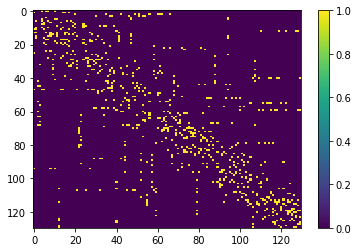

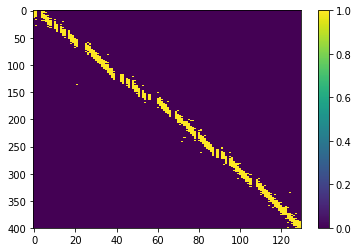

In [4]:
place_information = {'place ids': [0], 'place fracs': [0.80]}

diagram = WiringDiagram('params/circuitparams.yaml', place_information)
diagram.generate_internal_connectivity()

external_kwargs = {}
external_kwargs['place information'] = diagram.place_information
external_kwargs['external place ids'] = [100, 101]
external_kwargs['cue information'] = diagram.place_information
external_kwargs['external cue ids'] = [102]

diagram.generate_external_connectivity(ar.cell_information, **external_kwargs)
diagram.generate_septal_connectivity()

plt.figure()
plt.imshow(diagram.internal_adj_matrices[0][0], aspect='auto')
plt.colorbar()
plt.show()


plt.figure()
plt.imshow(diagram.external_adj_matrices[100][0], aspect='auto')
plt.colorbar()
plt.show()


In [5]:
def pull_spike_times(population2info_dict):
    spike_times = []
    gids = np.sort(list(population2info_dict.keys()))
    for gid in gids:
        spike_times.append(population2info_dict[gid]['spike times'])
    return spike_times

mf_spike_times  = pull_spike_times(ar.cell_information['MF']['cell info'])
mec_spike_times = pull_spike_times(ar.cell_information['MEC']['cell info'])
lec_spike_times = pull_spike_times(ar.cell_information['LEC']['cell info'])
bk_spike_times  = pull_spike_times(ar.cell_information['Background']['cell info'])

In [134]:
circuit = Circuit('params/circuitparams_ripple.yaml', diagram.pop2id, diagram.external_pop2id)
circuit.build_cells()
circuit.build_internal_netcons(diagram.internal_adj_matrices)
circuit.build_external_netcons(100, diagram.external_adj_matrices[100], mf_spike_times)
circuit.build_external_netcons(101, diagram.external_adj_matrices[101], mec_spike_times)
circuit.build_external_netcons(102, diagram.external_adj_matrices[102], lec_spike_times)
circuit.build_external_netcons(103, diagram.external_adj_matrices[103], bk_spike_times)
circuit.record_lfp([0,1])

#circuit.build_septal_netcons(diagram.septal_adj_matrices)

In [135]:
# this assumes plasticity is off

#model_filepath =  'models/48-trained-cue-on-inhplas-off-lecplas-off-15iter.npz'
model_filepath =  'models/48-trained-cue-on-inhplas-ie-lecplas-off-20iter.npz'



f = np.load(model_filepath, allow_pickle=True)
fkeys = f.keys()
for fk in fkeys:
    try: fk = int(fk)
    except: 
        print('fail:',fk)
        continue

    population_info = circuit.neurons[fk]
    weights = f[str(fk)]
    counter = 0
    for cell_gid in population_info.keys():
        cell_info = population_info[cell_gid]
        for (presynaptic_gid, nc, _) in cell_info.internal_netcons:
            for netcon in nc:
                base_weight  = weights[counter]
                added_weight = weights[counter + 1]
                total_weight = base_weight + added_weight
                if fk == 0 and presynaptic_gid >= 130: 
                    total_weight *= 0.50
                netcon.weight[0] = total_weight
                counter += 2
        for external_id in cell_info.external_netcons.keys():
            external_cell_info = cell_info.external_netcons[external_id]
            for (idx,(presynaptic_gid, nc, compartment)) in enumerate(external_cell_info):
                for netcon in nc:
                    base_weight  = weights[counter]
                    added_weight = weights[counter + 1]
                    total_weight = base_weight + added_weight
                    netcon.weight[0] = total_weight
                    counter += 2 
    print(len(weights), counter)
    

fail: frs
fail: spikes
fail: valid_gids
47800 47800
14760 14760


In [136]:
import time

h.load_file("stdrun.hoc")

def get_population_voltages(c,pop_id):
    v_vecs = []
    for i in range(len(c.neurons[pop_id])):
        v_vec = h.Vector()
        try:
            v_vec.record(c.neurons[pop_id][i].axon(0.5)._ref_v)
        except:
            v_vec.record(c.neurons[pop_id][i].soma(0.5)._ref_v)
        v_vecs.append(v_vec)
    return v_vecs

exc_v_vecs    = get_population_voltages(circuit, 0)
pvbc_v_vecs    = get_population_voltages(circuit, 1)
# aac_v_vecs   = get_population_voltages(2)
# bis_v_vecs   = get_population_voltages(3)
# olm_v_vecs   = get_population_voltages(4)
# isccr_v_vecs = get_population_voltages(5)
# iscck_v_vecs = get_population_voltages(6)

print('starting simulation..')
    
t_vec = h.Vector()  # Time stamp vector
t_vec.record(h._ref_t)

tic = time.time()

h.dt = 0.5
h.tstop =  time_for_single_lap * 4. + 500
h.finitialize(-65.0)
h.fadvance()
h.continuerun(h.tstop)

elapsed = time.time() - tic
print('that took %0.3f seconds' % elapsed)

starting simulation..
that took 221.399 seconds


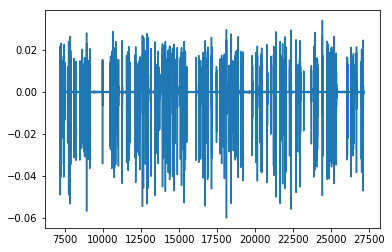

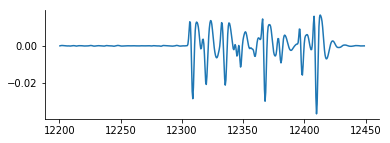

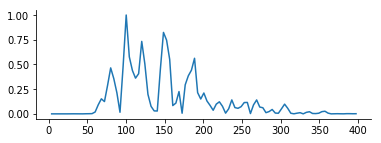

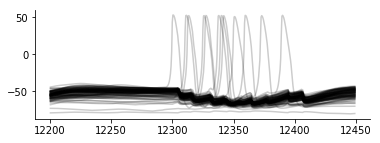

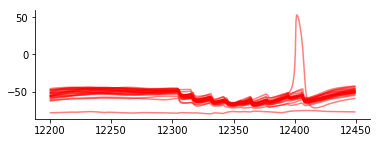

In [124]:
from analysis_utils import butter_bandpass_filter
from scipy.signal import welch, spectrogram

lfp = circuit.lfp
lfp_np = np.asarray([np.asarray(l, dtype='float32') for l in lfp], dtype='float32')
lfp_mean = lfp_np.mean(axis=0)
lfp_filtered = butter_bandpass_filter(lfp_mean, 100.0, 330.0, 2000., order=3)

start = np.where(np.asarray(t_vec) > time_for_single_lap*1+500)[0][0]
end   = np.where(np.asarray(t_vec) < time_for_single_lap*4+500)[0][-1]

plt.figure()
plt.plot(list(t_vec)[start:end], lfp_filtered[start:end])
plt.show()

t_vec = np.asarray(t_vec)

# s = np.where(t_vec > 15100)[0][0]
# e = np.where(t_vec < 15300)[0][-1]

# b3 ko
# s = np.where(t_vec > 15125)[0][0]
# e = np.where(t_vec < 15400)[0][-1]

s = np.where(t_vec > 12200)[0][0]
e = np.where(t_vec < 12450)[0][-1]



fig = plt.figure(figsize=(6,2))
ax  = fig.gca()
plt.plot(t_vec[s:e], lfp_filtered[s:e])
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)
    
    
flfp, plfp = welch(lfp_filtered[s:e], fs=2000.0, nperseg=512)
fig = plt.figure(figsize=(6,2))
ax  = fig.gca()
plt.plot(flfp[1:100], plfp[1:100]/plfp[1:100].max())
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)

fig = plt.figure(figsize=(6,2))
ax  = fig.gca()
plt.plot(t_vec[s:e], np.asarray(exc_v_vecs).T[s:e, diagram.place_information[0]['place']], color='k', alpha=0.2)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)
    
fig = plt.figure(figsize=(6,2))
ax  = fig.gca()
plt.plot(t_vec[s:e], np.asarray(exc_v_vecs).T[s:e, diagram.place_information[0]['not place']], color='r', alpha=0.5)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)

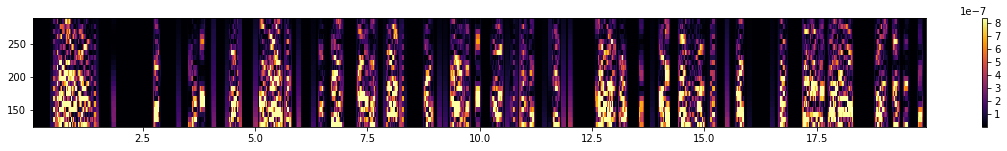

In [89]:

start = np.where(np.asarray(t_vec) > time_for_single_lap*1+500)[0][0]
end   = np.where(np.asarray(t_vec) < time_for_single_lap*4+500)[0][-1]

lfp_f, lfp_t, lfp_S = spectrogram(lfp_filtered[start:end], fs=2000., nperseg=256, noverlap=255)
fs, fe = np.where(lfp_f >= 125.0)[0][0], np.where(lfp_f <= 300)[0][-1]
lfp_S_reduced = lfp_S[fs:fe,:]
minn = np.percentile(lfp_S_reduced, 5.)
maxx = np.percentile(lfp_S_reduced, 95.)

plt.figure(figsize=(20,2))
plt.pcolormesh(lfp_t, lfp_f[fs:fe], lfp_S_reduced, vmin=minn, vmax=maxx, cmap='inferno')
plt.colorbar()
plt.show()


place-cue corr (0.28998639113289804, 0.0006160069534228578)
place-pvbc corr (0.9704197538110908, 1.3898769099227626e-84)
pvbc-cue corr (0.4491673244065234, 4.1361215037136195e-08)


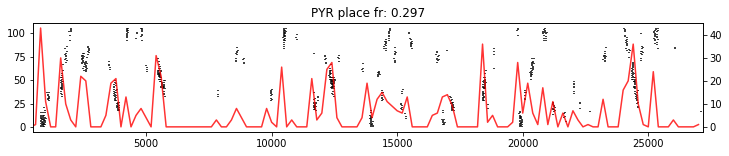

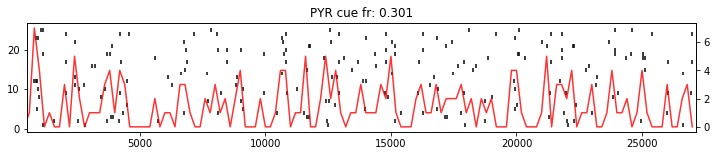

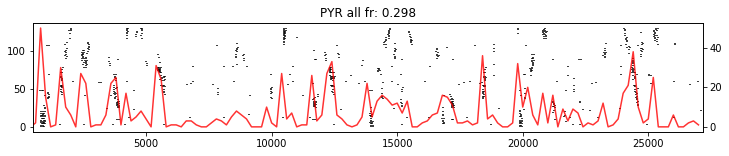

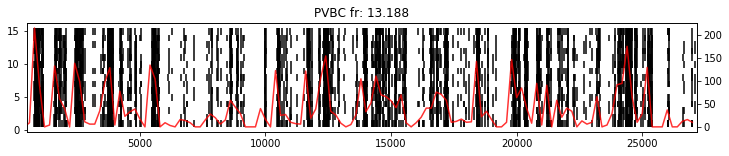

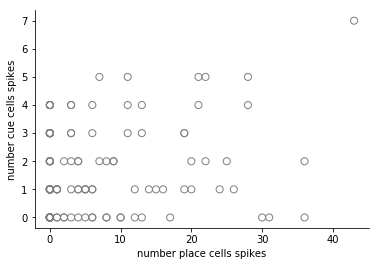

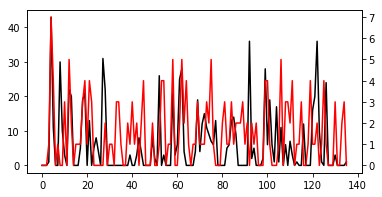

r,p 0.23118229245788302 0.006770521659312905


In [137]:
def plot_spikes(c, population_id, title, start, finish, gids=None):
    spike_times = c.get_cell_spikes(population_id)
    if gids is not None:
        temp_spike_times = []
        for i in range(len(spike_times)):
            if i in gids:
                temp_spike_times.append(spike_times[i])
        spike_times = temp_spike_times
        
    frs = []
    fig, ax = plt.subplots(figsize=(12,2))
    for (i,sts) in enumerate(spike_times):
        sts = np.asarray(sts)
        ax.vlines(np.asarray(sts), i+0.5, i+1.5)
        sts_chop = sts[np.where( (sts>=start) & (sts<=finish)) [0]]
        frs.append(float(len(sts_chop)) / (finish-start) * 1000.)
    ax.set_xlim([start, finish])
    ax.set_title('%s fr: %0.3f' % (title, np.mean(frs)))
    ax2 = ax.twinx()
    
    tick = 0
    jump = 200 #25ms hops
    nspikes = []
    while tick < finish:
        curr_nspikes = 0
        for (i,sts) in enumerate(spike_times):
            tick_end = tick + jump
            sts = np.asarray(sts)
            sts_chop = sts[np.where( (sts>=tick) & (sts<=tick_end)) [0]]
            curr_nspikes += len(sts_chop)
        tick += jump
        nspikes.append(curr_nspikes)
    ax2.plot([i*jump for i in range(len(nspikes))],nspikes, color='r', alpha=0.8)
    ax2.set_xlim([start, finish])
    return nspikes

start  = time_for_single_lap * 0 + 500
finish = time_for_single_lap * 4 + 500

nspikes_place = plot_spikes(circuit, 0, 'PYR place', start, finish, diagram.place_information[0]['place'])
nspikes_cue   = plot_spikes(circuit, 0, 'PYR cue', start, finish, diagram.place_information[0]['not place'])
nspikes_total = plot_spikes(circuit, 0, 'PYR all', start, finish, np.arange(130))


nspikes_pvbc  = plot_spikes(circuit, 1, 'PVBC', start, finish)
# plot_spikes(c, 2, 'AAC', start, finish)
# plot_spikes(c, 3, 'BiS', start, finish)
# plot_spikes(c, 4, 'OLM', start, finish)
# plot_spikes(c, 5, 'ISCCR', start, finish)
#plot_spikes(6, 'ISCCK', start, finish)
from scipy.stats import pearsonr

print('place-cue corr', pearsonr(nspikes_place, nspikes_cue))
print('place-pvbc corr', pearsonr(nspikes_place, nspikes_pvbc))
print('pvbc-cue corr', pearsonr(nspikes_pvbc, nspikes_cue))

fig = plt.figure()
ax  = fig.gca()
plt.scatter(nspikes_place, nspikes_cue, facecolor='none', edgecolor='gray', s=50)
plt.xlabel('number place cells spikes')
plt.ylabel('number cue cells spikes')
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)
plt.show()

fig, ax = plt.subplots(figsize=(6,3))
ax.plot(nspikes_place, color='k')
ax2 = ax.twinx()
ax2.plot(nspikes_cue, color='r')
plt.show()

from scipy.stats import pearsonr, spearmanr
r, p = spearmanr(nspikes_place, nspikes_cue)
print('r,p', r, p)

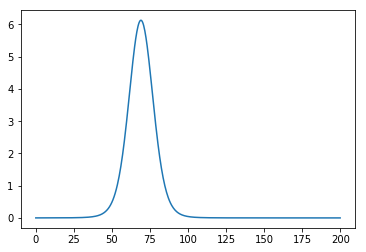

[]

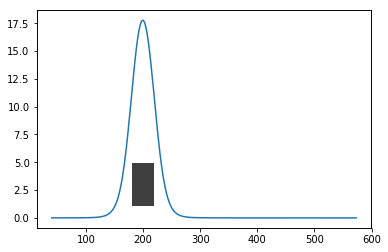

In [137]:
all_exc_frs = []
all_exc_spikes = []
valid_gids = []
start_time = time_for_single_lap * 0 + 500
end_time   = time_for_single_lap * 1 + 500

for i in circuit.neurons[0].keys():
    exc_spikes = np.asarray(circuit.neurons[0][i].spike_times)

    time_idxs = np.where( (exc_spikes >= start_time) & (exc_spikes <= end_time))[0]
    exc_spikes = exc_spikes[time_idxs]
    all_exc_spikes.append(exc_spikes)
    step = 12.5 # ms
    estimated_times = np.arange(start_time, end_time, step=step)

    try:
        estimated_fr,_ = baks(exc_spikes/1000., estimated_times/1000., a=10.0) # 1.75?
        all_exc_frs.append(estimated_fr)
        valid_gids.append(i)
    except:
        continue
all_exc_frs = np.asarray(all_exc_frs, dtype='float32')

idx = 30
plt.figure()
plt.plot(estimated_times/1000*30. - start_time/1000*30, all_exc_frs[valid_gids[idx]])
plt.show()

fig, ax = plt.subplots()
ax.plot(estimated_times/step, all_exc_frs[idx])
ax2 = ax.twinx()
ax2.vlines(all_exc_spikes[valid_gids[idx]]/step, 0.5, 1.5)
ax2.set_ylim([0, 5])
ax2.set_yticks([])


[0, 1, 2, 4, 5, 6, 9, 10, 11, 12, 14, 15, 18, 19, 20, 21, 22, 23, 24, 26, 28, 29, 30, 31, 32, 34, 36, 38, 39, 40, 42, 43, 45, 48, 49, 50, 51, 52, 53, 55, 57, 58, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 80, 81, 83, 85, 86, 87, 89, 91, 92, 93, 94, 95, 97, 98, 101, 104, 105, 106, 107, 110]


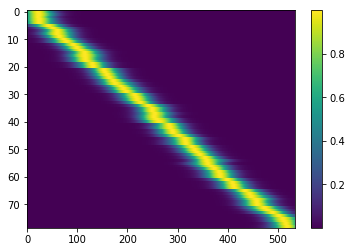

{0, 1}


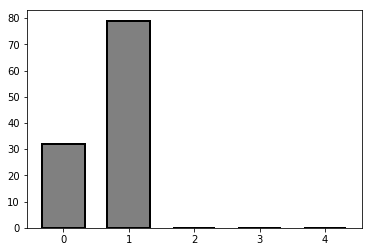

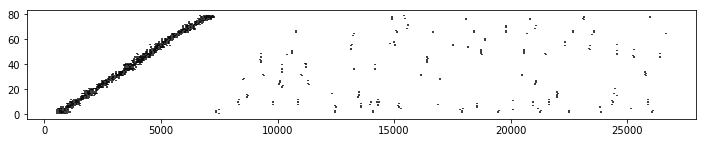

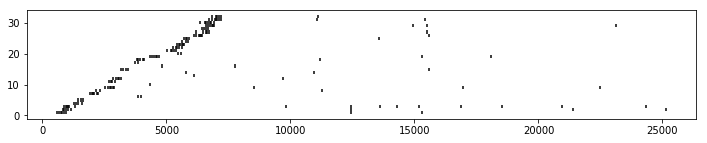

In [139]:


valid_idxs = []
invalid_idxs = []
for i in range(len(all_exc_frs)):
    sl = all_exc_frs[i]
    if not np.all(sl < 10.0): valid_idxs.append(i)
    else: 
        invalid_idxs.append(i)
valid_exc_frs = all_exc_frs[valid_idxs,:] # flip a rooni
print(valid_idxs)

normed = []
for i in range(len(valid_exc_frs)):
    normed.append(valid_exc_frs[i] / valid_exc_frs[i].max())
normed = np.asarray(normed, dtype='float32')

whereismax = []
for i in range(len(normed)):
    sl = normed[i,:]
    whereismax.append(sl.argmax())
sorted_max = np.argsort(whereismax)

normed_sorted        = normed[sorted_max,:]
valid_exc_frs_sorted = valid_exc_frs[sorted_max,:]


plt.figure()
plt.imshow(normed_sorted, cmap='viridis', aspect='auto')
plt.colorbar()
plt.show()



# fig, ax = plt.subplots(5, 5, figsize=(12,8))
# for i in range(25):
#     xx = int(i/5)
#     yy = int(i%5)
#     ax[xx,yy].plot(estimated_times, normed_sorted[i])
#     ax[xx,yy].hlines(0.80, estimated_times[0], estimated_times[-1], linestyle='--')
#     ax[xx,yy].set_title(i)
    
ncrossed = []
for i in range(len(valid_exc_frs_sorted)):
    sl = normed_sorted[i]
    crossed = False
    ticks = 0
    for s in sl:
        if s > 0.80 and not crossed: 
            crossed = True
            ticks += 1
        if s <= 0.80 and crossed:
            crossed = False
    ncrossed.append(ticks)

ncrossed = np.asarray(ncrossed + [0 for _ in range(len(all_exc_frs) - len(valid_exc_frs))])
print(set(ncrossed))
plt.figure()
plt.hist(ncrossed, bins=[0,1,2,3,4,5], align='left', rwidth=0.65, 
         edgecolor='k', color='gray', linewidth=2)
plt.show()

spike_times = np.asarray(circuit.get_cell_spikes(0))[valid_gids]
valid_raster = []
for nid in np.asarray(valid_idxs)[sorted_max]:
    valid_raster.append(spike_times[nid])

plt.figure(figsize=(12,2))
for (i,sts) in enumerate(valid_raster):
    sts = np.asarray(sts)
    plt.vlines(np.asarray(sts), i+0.5, i+1.5)
#plt.xlim([start_time, end_time])
#plt.xlim([end_time, end_time+time_for_single_lap])
plt.show()


invalid_raster = []
for nid in invalid_idxs:
    invalid_raster.append(spike_times[nid])

plt.figure(figsize=(12,2))
for (i,sts) in enumerate(invalid_raster):
    sts = np.asarray(sts)
    plt.vlines(np.asarray(sts), i+0.5, i+1.5)
#plt.xlim([start_time, end_time])
#plt.xlim([end_time, end_time+time_for_single_lap])
plt.show()


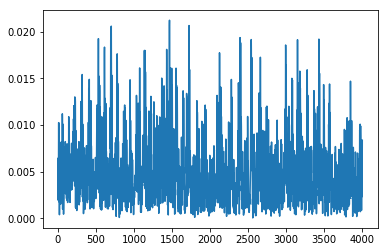

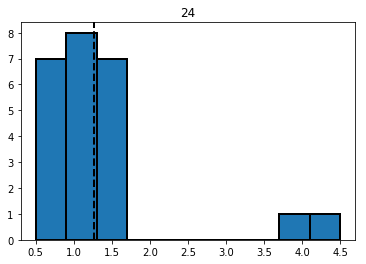

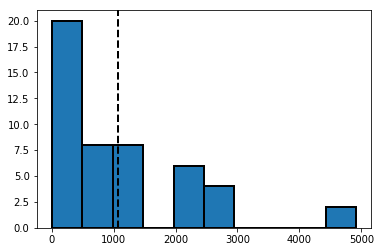

In [130]:
from scipy.signal import hilbert

lfp_analytic = hilbert(lfp_filtered)
lfp_envelope = np.abs(lfp_analytic)
plt.figure()
plt.plot(lfp_envelope[2000:6000])

mean_filt = lfp_envelope.mean()
std_filt  = lfp_envelope.std()
cutoff = mean_filt + 5.0*std_filt

ripple_start, ripple_end = [], []
intra_ripple_duration = []
in_ripple = 0

for i in range(len(lfp_envelope)):
        val = lfp_envelope[i]
        if in_ripple:
            if val < cutoff:
                ripple_end.append(i)
                in_ripple = 0
        else:
            if val >= cutoff:
                ripple_start.append(i)
                in_ripple = 1
                if len(ripple_end) > 0:
                    intra_rip_dur = (i-ripple_end[-1])*0.5
                    intra_ripple_duration.append(intra_rip_dur)
                    if intra_rip_dur < 10.0:
                        ripple_start = ripple_start[:-1]
                        ripple_end   = ripple_end[:-1]
                    else: intra_ripple_duration.append(intra_rip_dur)

 
durations = []
for rs, re in list(zip(ripple_start, ripple_end)):
    durations.append( (re-rs)*0.5)
plt.figure()
plt.hist(durations, bins=10, edgecolor='k', linewidth=2)
plt.axvline(np.mean(durations), linestyle='--', color='k', linewidth=2)
plt.title(len(durations))
plt.show()

plt.figure()
plt.hist(intra_ripple_duration, bins=10, edgecolor='k', linewidth=2)
plt.axvline(np.mean(intra_ripple_duration), linestyle='--', color='k', linewidth=2)
plt.show()

